In [115]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [116]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
import math
import cv2 as cv
import copy
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras import backend as K
from keras.utils import Sequence
from keras import optimizers
import pylab
from sklearn.metrics import accuracy_score
import h5py
import skimage
from skimage import transform
from keras.utils import CustomObjectScope
from keras.models import load_model

In [117]:
Train_masks = pd.read_csv('./train_masks.csv')

In [118]:
Train_masks.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [119]:
img_ids = Train_masks['img'].tolist()
train_ids = list(map(lambda x: x.split('.')[0]+'.jpg',img_ids))
mask_ids = list(map(lambda x: x.split('.')[0]+'_mask.gif',img_ids))


In [120]:
Train_path = './train/'
Mask_path = './train_masks/'

In [121]:
trn_ids_img,val_ids_img,trn_ids_mask,val_ids_mask = train_test_split(train_ids,mask_ids,test_size=0.1)

In [122]:
num_trn = len(trn_ids_img)
num_val = len(val_ids_img)
num_trn, num_val

(4579, 509)

In [123]:
IMG_H, IMG_W, NUM_C = 320, 480, 3

In [124]:
mean_all = np.array([0.69835544, 0.69106046, 0.68405914])
std_all= np.array([0.24336825, 0.24748387, 0.24431731])

In [125]:
class train_ds():
    
    def __init__(self):
        return
    
    def __getitem__(self,indx):
        return self.get_img(indx),self.get_mask(indx)
       
    
    def get_mask(self,indx):
        mask =mpimg.imread(Mask_path+trn_ids_mask[indx])
        mask = mask[:,:,0]/255
        mask = np.pad(mask,((0,0),(1,1)),mode='edge')
        mask = skimage.transform.resize(mask,(IMG_H,IMG_W))
        mask = np.around(mask)
        mask = np.expand_dims(mask,-1)
        return mask
    
    def get_img(self,indx):
        img = mpimg.imread(Train_path+trn_ids_img[indx])
        img = np.pad(img,((0,0),(1,1),(0,0)),mode='edge')
        img = skimage.transform.resize(img,(IMG_H,IMG_W,NUM_C))
        img = (img-mean_all)/std_all
        return img
        
    
    def __len__(self):
        return num_trn
    

In [126]:
class valid_ds():
    
    def __init__(self):
        return
    
    def __getitem__(self,indx):
        return self.get_img(indx),self.get_mask(indx)
    
    def get_mask(self,indx):
        mask =mpimg.imread(Mask_path+val_ids_mask[indx])
        mask = mask[:,:,0]/255
        mask = np.pad(mask,((0,0),(1,1)),mode='edge')
        mask = skimage.transform.resize(mask,(IMG_H,IMG_W))
        mask = np.around(mask)
        mask = np.expand_dims(mask,-1)
        return mask
    
    def get_img(self,indx):
        img = mpimg.imread(Train_path+val_ids_img[indx])
        img = np.pad(img,((0,0),(1,1),(0,0)),mode='edge')
        img = skimage.transform.resize(img,(IMG_H,IMG_W,NUM_C))
        img=(img-mean_all)/std_all
        return img
    
    def __len__(self):
        return num_val
    

In [127]:
trn_ds = train_ds() 
val_ds = valid_ds()

In [128]:
class train_dl(Sequence):
    def __init__(self,bs=32):
        self.bs = bs
        self.num_batch = len(self)
        self.num_img = self.bs * self.num_batch
        self.indices = np.split(np.random.permutation(self.num_img),self.num_batch)
        
    
    def on_epoch_end(self):
        self.indices = np.split(np.random.permutation(self.num_img),self.num_batch)
        
        
        
    def __len__(self):
        return num_trn // self.bs
    
    def __getitem__(self,indx):
        batch = [trn_ds[i] for i in self.indices[indx]]
        batch_img = np.array([data[0] for data in batch])
        batch_mask = np.array([data[1] for data in batch])
        return batch_img,batch_mask
    
  
        

In [129]:
class valid_dl(Sequence):
    def __init__(self,bs=32):
        self.bs = bs
        self.num_batch = len(self)
        self.num_img = self.bs * self.num_batch
        self.indices = np.split(np.arange(0,self.num_img),self.num_batch)
        
    def __len__(self):
        return num_val // self.bs
    
    def __getitem__(self,indx):
        batch = [val_ds[i] for i in self.indices[indx]]
        batch_img = np.array([data[0] for data in batch])
        batch_mask = np.array([data[1] for data in batch])
        return batch_img,batch_mask

In [130]:
def make_unet():
    
    
    data = layers.Input(shape=(IMG_H,IMG_W,NUM_C))


    conv1a = layers.Conv2D(64,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(data)
    conv1b = layers.Conv2D(64,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv1a)
    pool1 = layers.MaxPooling2D(pool_size=2,padding='same',data_format = 'channels_last')(conv1b)


    conv2a = layers.Conv2D(128,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(pool1)
    conv2b = layers.Conv2D(128,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv2a)
    pool2 = layers.MaxPooling2D(pool_size=2,padding='same',data_format = 'channels_last')(conv2b)


    conv3a = layers.Conv2D(256,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(pool2)
    conv3b = layers.Conv2D(256,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv3a)
    pool3 = layers.MaxPooling2D(pool_size=2,padding='same',data_format = 'channels_last')(conv3b)


    conv4a = layers.Conv2D(512,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(pool3)
    conv4b = layers.Conv2D(512,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv4a)
    pool4 = layers.MaxPooling2D(pool_size=2,padding='same',data_format = 'channels_last')(conv4b)


    conv5a = layers.Conv2D(1024,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(pool4)
    conv5b = layers.Conv2D(1024,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv5a)


    #upsamp6 = layers.UpSampling2D(size=2,data_format='channels_last')(conv5b)

    #conv6a = layers.Conv2D(512,2,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
    #                           kernel_initializer = 'he_normal',bias_initializer='zeros')(upsamp6)
    
    conv6a =  layers.Conv2DTranspose(512,2,strides=2,padding='same',data_format = 'channels_last',activation='relu',
                                    use_bias=True,kernel_initializer = 'he_normal',bias_initializer='zeros')(conv5b)

    merge6 = layers.Concatenate(axis=-1)([conv6a,conv4b])

    conv6b = layers.Conv2D(512,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(merge6)
    conv6c = layers.Conv2D(512,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv6b)


    #upsamp7 = layers.UpSampling2D(size=2,data_format='channels_last')(conv6c)

    #conv7a = layers.Conv2D(256,2,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
    #                           kernel_initializer = 'he_normal',bias_initializer='zeros')(upsamp7)
    
    conv7a =  layers.Conv2DTranspose(256,2,strides=2,padding='same',data_format = 'channels_last',activation='relu',
                                    use_bias=True,kernel_initializer = 'he_normal',bias_initializer='zeros')(conv6c)


    merge7 = layers.Concatenate(axis=-1)([conv7a,conv3b])

    conv7b = layers.Conv2D(256,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(merge7)
    conv7c = layers.Conv2D(256,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv7b)


    #upsamp8 = layers.UpSampling2D(size=2,data_format='channels_last')(conv7c)

    #conv8a = layers.Conv2D(128,2,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
    #                           kernel_initializer = 'he_normal',bias_initializer='zeros')(upsamp8)
    
    conv8a =  layers.Conv2DTranspose(128,2,strides=2,padding='same',data_format = 'channels_last',activation='relu',
                                    use_bias=True,kernel_initializer = 'he_normal',bias_initializer='zeros')(conv7c)


    merge8 = layers.Concatenate(axis=-1)([conv8a,conv2b])

    conv8b = layers.Conv2D(128,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(merge8)
    conv8c = layers.Conv2D(128,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv8b)


    #upsamp9 = layers.UpSampling2D(size=2,data_format='channels_last')(conv8c)

    #conv9a = layers.Conv2D(64,2,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
    #                           kernel_initializer = 'he_normal',bias_initializer='zeros')(upsamp9)
    
    conv9a =  layers.Conv2DTranspose(64,2,strides=2,padding='same',data_format = 'channels_last',activation='relu',
                                    use_bias=True,kernel_initializer = 'he_normal',bias_initializer='zeros')(conv8c)


    merge9 = layers.Concatenate(axis=-1)([conv9a,conv1b])

    conv9b = layers.Conv2D(64,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(merge9)
    conv9c = layers.Conv2D(64,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv9b)

    final = layers.Conv2D(1,1,strides=1,padding='same',data_format='channels_last',activation='sigmoid',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv9c)


    unet = Model(inputs = data, outputs = final)
    
    return unet


In [131]:
unet = make_unet()

In [132]:
def Dice_coefficient(y_true,y_pred,threshold=0.5):
    
    y_pred = K.squeeze(y_pred,axis=-1)
    y_thresh = threshold * K.ones_like(y_pred)
    y_pred = K.greater(y_pred,y_thresh)
    y_pred = K.cast(y_pred,'float32')
    y_true = K.squeeze(y_true,axis=-1)
    y_true = K.cast(y_true,'float32')
    size_pred = K.sum(y_pred)
    size_true = K.sum(y_true)
    inter = y_pred * y_true
    size_inter = K.sum(inter)
    
    dice = 2 * size_inter/(size_pred + size_true)
    
    
    
    return dice
    
    
    
    
    

In [133]:
def Dice_metric(y_true,y_pred):
    return Dice_coefficient(y_true,y_pred,threshold=0.5)

In [134]:
optimizer = optimizers.Adam(lr=0.001)
unet.compile(optimizer = optimizer,loss = 'binary_crossentropy',metrics = [Dice_metric])
trn_dl_fit=train_dl(bs=4)
val_dl_fit=valid_dl(bs=4)
unet.fit_generator(trn_dl_fit,epochs=5,validation_data=val_dl_fit,shuffle=False,workers=8)

Epoch 1/5


/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1144/1144 [==============================] - 831s 727ms/step - loss: 0.0664 - Dice_metric: 0.9378 - val_loss: 0.0160 - val_Dice_metric: 0.9852
Epoch 2/5
1144/1144 [==============================] - 842s 736ms/step - loss: 0.0129 - Dice_metric: 0.9885 - val_loss: 0.0099 - val_Dice_metric: 0.9911
Epoch 3/5
1144/1144 [==============================] - 827s 723ms/step - loss: 0.0335 - Dice_metric: 0.9716 - val_loss: 0.0091 - val_Dice_metric: 0.9915
Epoch 4/5
1144/1144 [==============================] - 822s 718ms/step - loss: 0.0121 - Dice_metric: 0.9892 - val_loss: 0.0087 - val_Dice_metric: 0.9919
Epoch 5/5
1144/1144 [==============================] - 824s 720ms/step - loss: 0.0140 - Dice_metric: 0.9881 - val_loss: 0.0099 - val_Dice_metric: 0.9909


In [135]:
optimizer = optimizers.Adam(lr=0.0001)
unet.compile(optimizer = optimizer,loss = 'binary_crossentropy',metrics = [Dice_metric])
trn_dl_fit=train_dl(bs=4)
val_dl_fit=valid_dl(bs=4)
unet.fit_generator(trn_dl_fit,epochs=5,validation_data=val_dl_fit,shuffle=False,workers=8)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch 1/5
1144/1144 [==============================] - 829s 724ms/step - loss: 0.0082 - Dice_metric: 0.9926 - val_loss: 0.0071 - val_Dice_metric: 0.9933
Epoch 2/5
1144/1144 [==============================] - 823s 719ms/step - loss: 0.0068 - Dice_metric: 0.9938 - val_loss: 0.0062 - val_Dice_metric: 0.9941
Epoch 3/5
1144/1144 [==============================] - 835s 730ms/step - loss: 0.0061 - Dice_metric: 0.9944 - val_loss: 0.0058 - val_Dice_metric: 0.9945
Epoch 4/5
1144/1144 [==============================] - 825s 721ms/step - loss: 0.0056 - Dice_metric: 0.9948 - val_loss: 0.0054 - val_Dice_metric: 0.9947
Epoch 5/5
1144/1144 [==============================] - 833s 728ms/step - loss: 0.0052 - Dice_metric: 0.9951 - val_loss: 0.0052 - val_Dice_metric: 0.9950


In [136]:
optimizer = optimizers.Adam(lr=0.00001)
unet.compile(optimizer = optimizer,loss = 'binary_crossentropy',metrics = [Dice_metric])
trn_dl_fit=train_dl(bs=4)
val_dl_fit=valid_dl(bs=4)
unet.fit_generator(trn_dl_fit,epochs=5,validation_data=val_dl_fit,shuffle=False,workers=8)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch 1/5
1144/1144 [==============================] - 830s 726ms/step - loss: 0.0048 - Dice_metric: 0.9954 - val_loss: 0.0050 - val_Dice_metric: 0.9951
Epoch 2/5
1144/1144 [==============================] - 813s 711ms/step - loss: 0.0048 - Dice_metric: 0.9955 - val_loss: 0.0050 - val_Dice_metric: 0.9952
Epoch 3/5
1144/1144 [==============================] - 820s 717ms/step - loss: 0.0047 - Dice_metric: 0.9955 - val_loss: 0.0050 - val_Dice_metric: 0.9952
Epoch 4/5
1144/1144 [==============================] - 825s 721ms/step - loss: 0.0047 - Dice_metric: 0.9955 - val_loss: 0.0049 - val_Dice_metric: 0.9952
Epoch 5/5
1144/1144 [==============================] - 827s 723ms/step - loss: 0.0046 - Dice_metric: 0.9956 - val_loss: 0.0049 - val_Dice_metric: 0.9952


In [ ]:
with CustomObjectScope({'Dice_metric':Dice_metric}):
    unet.save('unet_lr_p001_epoch_5_lr_p0001_epoch_5_lr_p00001_epoch_5.h5') 

In [137]:
with CustomObjectScope({'Dice_metric':Dice_metric}):
    unet = load_model('unet_lr_p001_epoch_5_lr_p0001_epoch_5_lr_p00001_epoch_5.h5') 

In [21]:
def plot_val(indx,TTA=False):
    val_im = val_ds[indx][0]
    val_mask = val_ds[indx][1]
    val_im_plot = val_im * std_all + mean_all
    plt.figure('val_im')
    plt.imshow(val_im_plot)
    val_mask = np.squeeze(val_mask)
    plt.figure('val_mask')
    plt.imshow(val_mask)
    if TTA is True:
        val_im_lr = np.fliplr(val_im)
        val_im_ud = np.flipud(val_im)
        val_im_lrud = np.fliplr(np.flipud(val_im))
        val_prob = unet.predict(np.array([val_im]))[0] + np.fliplr(unet.predict(np.array([val_im_lr]))[0]) \
        + np.flipud(unet.predict(np.array([val_im_ud]))[0]) + np.flipud(np.fliplr(unet.predict(np.array([val_im_lrud]))[0]))    
        val_prob = val_prob/4.0
    else: 
        val_prob = unet.predict(np.array([val_im]))[0] 
    val_prob = np.squeeze(val_prob)
    val_pred = val_prob > 0.5
    plt.figure('val_pred')
    plt.imshow(val_pred)
    val_diff = np.abs(val_pred - val_mask)
    plt.figure('val_diff')
    plt.imshow(val_diff)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


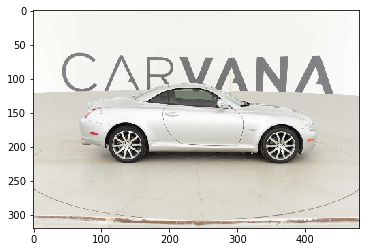

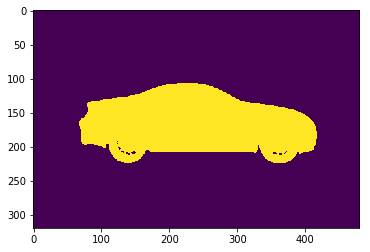

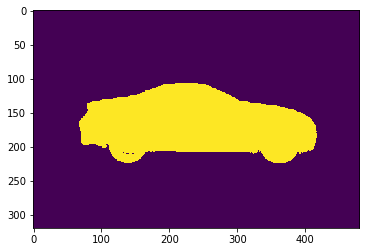

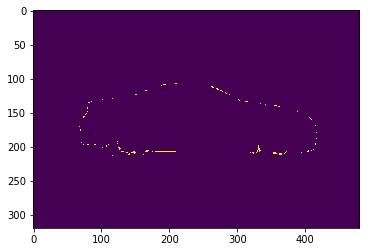

In [22]:
plot_val(0)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


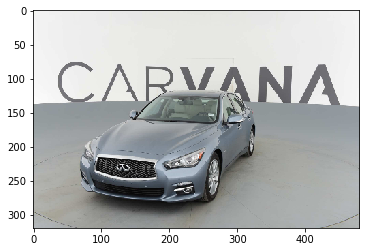

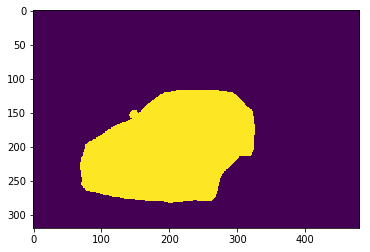

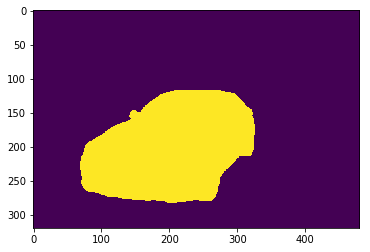

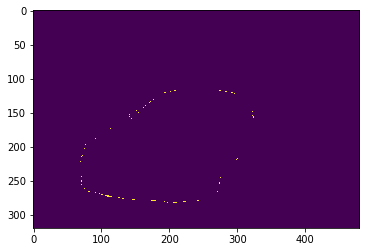

In [23]:
indx = np.random.randint(num_val)
plot_val(indx)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


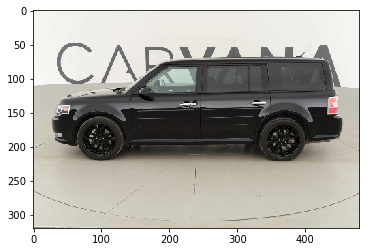

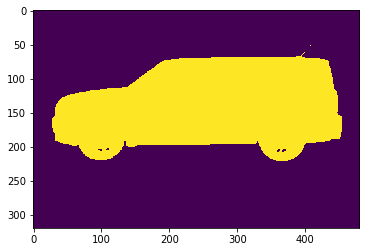

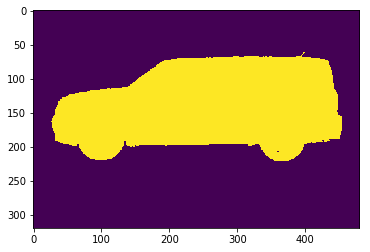

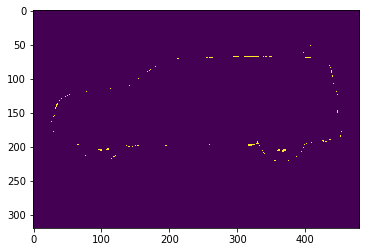

In [24]:
indx = np.random.randint(num_val)
plot_val(indx)

In [34]:
sample_submission = pd.read_csv('./sample_submission.csv')
test_ids = sample_submission['img'].tolist()
num_test = len(test_ids)
Test_path = './test/'

In [30]:
class test_ds():
    
    def __init__(self):
        return
    
    def __getitem__(self,indx):
        return self.get_img(indx)
       
    
    def get_img(self,indx):
        img = mpimg.imread(Test_path+test_ids[indx])
        img = np.pad(img,((0,0),(1,1),(0,0)),mode='edge')
        img = skimage.transform.resize(img,(IMG_H,IMG_W,NUM_C))
        img = (img-mean_all)/std_all
        return img
        
    
    def __len__(self):
        return num_test

In [31]:
tst_ds = test_ds()

In [38]:
def plot_test(indx,TTA=False):
    val_im = tst_ds[indx]
    val_im_plot = val_im * std_all + mean_all
    plt.figure('val_im')
    plt.imshow(val_im_plot)
    if TTA is True:
        val_im_lr = np.fliplr(val_im)
        val_im_ud = np.flipud(val_im)
        val_im_lrud = np.fliplr(np.flipud(val_im))
        val_prob = unet.predict(np.array([val_im]))[0] + np.fliplr(unet.predict(np.array([val_im_lr]))[0]) \
        + np.flipud(unet.predict(np.array([val_im_ud]))[0]) + np.flipud(np.fliplr(unet.predict(np.array([val_im_lrud]))[0]))    
        val_prob = val_prob/4.0
    else: 
        val_prob = unet.predict(np.array([val_im]))[0] 
    val_prob = np.squeeze(val_prob)
    val_pred = val_prob > 0.5
    plt.figure('val_pred')
    plt.imshow(val_pred)
    

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


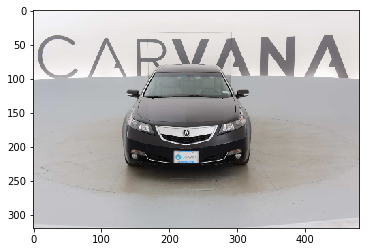

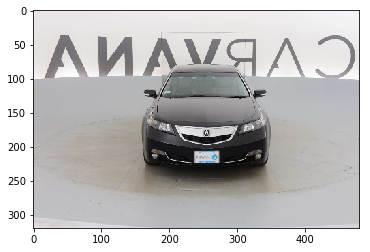

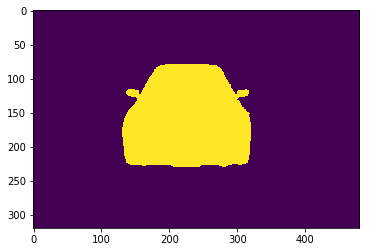

In [33]:
plot_test(0)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


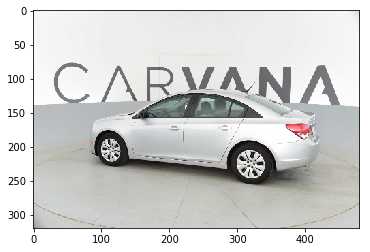

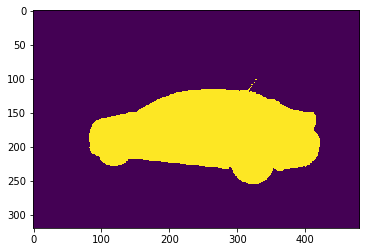

In [39]:
indx = np.random.randint(num_test)
plot_test(indx)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


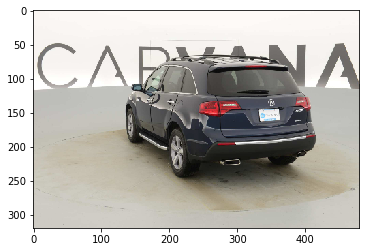

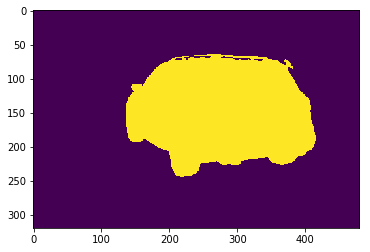

In [40]:
indx = np.random.randint(num_test)
plot_test(indx)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


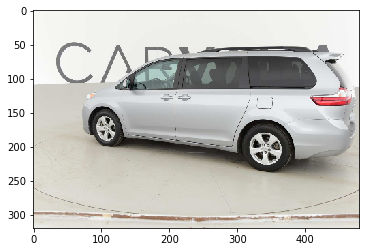

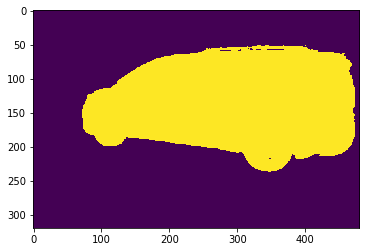

In [73]:
indx = np.random.randint(num_test)
plot_test(indx)